<img src="./pics/DL.png" width=110 align="left" style="margin-right: 10px">

# Introduction to Deep Learning

## 05. Home Assignment I.

---

## Silent MNIST

<p><a href="https://commons.wikimedia.org/wiki/File:%D9%84%D8%BA%D8%A9_%D8%A7%D9%84%D8%A7%D8%B4%D8%A7%D8%B1%D8%A9_%D8%A7%D9%84%D8%A7%D9%85%D8%B1%D9%8A%D9%83%D9%8A%D8%A9.png#/media/File:لغة_الاشارة_الامريكية.png"><img src="./pics/exercises/silent_mnist.png" width=400></a><br>By <a href="//commons.wikimedia.org/w/index.php?title=User:Krzys_kurd&amp;action=edit&amp;redlink=1" class="new" title="User:Krzys kurd (page does not exist)">Krzys kurd</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=24699115">Link</a></p>

### Description

Create a silent number detector using the different pictures taken of the signers hands. Your task is to create a neural network to solve this problem, using dense layers. You are free to use any kind of preprocessing or any kind of transformation on the data, and you can use any discussed methods.  
Your designed solution must be presented in a form of clean, structured and well commented code. Descriptions should include the designed network layouts and the reasoning behind the choices. The final results should be highlighted, saved ([tutorial](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)) and easily reproduceable.  
Creating parametrizable functions to dynamically generate networks is a plus.

### About the data

The pictures are already preprocessed and transformed into greyscale image matrices.  
The target variable is the value of the associated sign in one-hot encoded form.  
Both feature matrix and target vectors are available as numpy arrays and can be found in the `data/sign_language/` folder. You can read `.npy` numpy array files with the `np.load("path_to_file.npy")` function.

### Table of Contents

### Import libraries

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


### Load and explore the dataset

In [27]:
X = np.load('data/sign_language/X.npy')
y = np.load('data/sign_language/y.npy')

In [28]:
print('Shape of X:', X.shape, '\nNumber of observations:', len(X))

Shape of X: (2062, 64, 64) 
Number of observations: 2062


We have 2062 observations in our dataset. Let's start exploring these by looking at one of the X values and its shape:

In [29]:
print('Array of values for X[0]:\n', X[0], '\n\nShape of X[0]:', X[0].shape)

Array of values for X[0]:
 [[0.47450978 0.46274507 0.45098037 ... 0.50196075 0.5137255  0.52549016]
 [0.46666664 0.45098037 0.43921566 ... 0.4980392  0.5098039  0.52156866]
 [0.45490193 0.43921566 0.42745095 ... 0.49411762 0.50196075 0.517647  ]
 ...
 [0.4470588  0.4352941  0.4235294  ... 0.49019605 0.4980392  0.5058824 ]
 [0.45490193 0.44313723 0.43137252 ... 0.4980392  0.5058824  0.5137255 ]
 [0.46274507 0.45098037 0.43921566 ... 0.50196075 0.5098039  0.52156866]] 

Shape of X[0]: (64, 64)


So we have 64x64 pixel images, and each pixel's greyscale value is between 0 and 1. In order for Keras to be able to consume this data, we have to flatten the matrix for each image.

In [30]:
input_dim = 64 * 64

X = X.flatten().reshape(len(X), input_dim)
print('Shape of X:', X.shape)

Shape of X: (2062, 4096)


Let's see what value this matrix represents:

In [31]:
print('y[0] in one-hot encoded form:', y[0], '\n\nShape of y[0]:', y[0].shape)

y[0] in one-hot encoded form: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

Shape of y[0]: (10,)


Based on the labels, this particular image should show a 0. 

Let's add a few other observations and see if our expectation meets what's actually shown in the images.

In [32]:
y_items = [0, 50, 500, 1000]
for i in y_items:
    print('y[{}] in one-hot encoded form:'.format(i), y[i])

y[0] in one-hot encoded form: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
y[50] in one-hot encoded form: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
y[500] in one-hot encoded form: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
y[1000] in one-hot encoded form: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


So we're expecting to see images of hands signing two 0s, a 2 and a 4.

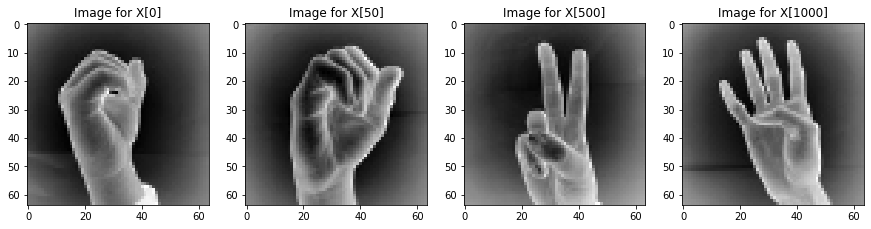

In [34]:
f, ax = plt.subplots(nrows=1, ncols=len(y_items), figsize=(15, 15))
for i in y_items:
    pos = y_items.index(i)  
    ax[pos].imshow(X[i].reshape(64, 64), cmap=plt.get_cmap('gray'))
    ax[pos].title.set_text('Image for X[{}]'.format(i))

Our assumption was correct, we can see two zeros, a 2 and a 4. 

Now that we have a pretty good idea what our data looks like, we can get to modeling.

### Network layout

#### Create train-test (75-25%) split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Create a baseline network

I worked with the MNIST dataset as part of an assignment for _Data Science 3: Machine Learning Tools_ earlier this year ([GitHub repo](https://github.com/szigony/ceu-ds3/blob/master/DS3_A2_Patrik-Szigeti.Rmd)), and I was able to achieve 88.7% prediction accuracy. Since it's generally a good practice to learn from ourselves, I'll use the specifications of my previously built model, and I'll try to see if I can improve upon that score.

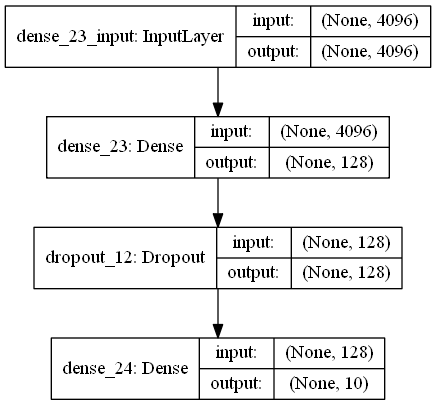

In [48]:
output_dim = 10

model_1 = Sequential()
model_1.add(Dense(units=128, input_dim=input_dim, activation='relu'))
model_1.add(Dropout(rate=0.3))
model_1.add(Dense(units=output_dim, activation='softmax'))

plot_model(model_1, show_shapes=True, show_layer_names=True)

In [52]:
model_1.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

np.random.seed(42)
model_1.fit(X_train, y_train, epochs=500, validation_split=0.2, batch_size=64, verbose=False)

model_1_loss, model_1_accuracy = model_1.evaluate(X_test, y_test)
print(f'The accuracy of the baseline model on the test set is {model_1_accuracy:.2%}')

516/516 [==============================] - 0s 27us/step
The accuracy of the baseline model on the test set is 42.83%


#### Test multiple possible networks